## [ERA5 Reanalysis](https://comptools.climatematch.io/tutorials/W1D2_StateoftheClimateOceanandAtmosphereReanalysis/student/W1D2_Tutorial2.html)

#### What is re-analysis?
[This video is linked](https://climate.copernicus.eu/climate-reanalysis) in the tutorial that defines weather/climate re-analysis. It is filling in missing pieces of the puzzle about the past climate/weather conditions from when there isn't a lot of data.

In [4]:
# !pip install pythia_datasets
# !pip install cartopy
# !pip install geoviews

# !pip install boto3 --quiet
# !pip install intake

In [58]:
from intake import open_catalog
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import fsspec
import numpy as np
import seaborn as sns

import boto3
import botocore
import datetime
import numpy as np
import os
import pooch
import tempfile
import geoviews as gv
import holoviews
from geoviews import Dataset as gvDataset
import geoviews.feature as gf
from geoviews import Image as gvImage

from cartopy import crs as ccrs
from cartopy import feature as cfeature

import warnings
#  Suppress warnings issued by Cartopy when downloading data files
warnings.filterwarnings('ignore')

In [6]:
## Helper function
def pooch_load(filelocation=None, filename=None, processor=None):
    shared_location = "/home/jovyan/shared/Data/tutorials/W1D2_StateoftheClimateOceanandAtmosphereReanalysis"  # this is different for each day
    user_temp_cache = tempfile.gettempdir()

    if os.path.exists(os.path.join(shared_location, filename)):
        file = os.path.join(shared_location, filename)
    else:
        file = pooch.retrieve(
            filelocation,
            known_hash=None,
            fname=os.path.join(user_temp_cache, filename),
            processor=processor,
        )

    return file

In [7]:
## Accessing ERA5 data from AWS for a specific date, e.g., March 1, 2018, midnight (0)

example_date = datetime.datetime(2018, 3, 1, 0)

era5_bucket = "era5-pds"
client = boto3.client(
    "s3", config=botocore.client.Config(signature_version=botocore.UNSIGNED)
)  # initialize aws s3 bucket client

prefix = example_date.strftime("%Y/%m/")  # format the date to match the s3 bucket
metadata_file = "main.nc"  # filename on the s3 bucket
metadata_key = prefix + metadata_file  # file location and name on the s3 bucket
filepath = pooch_load(
    filelocation="http://s3.amazonaws.com/" + era5_bucket + "/" + metadata_key,
    filename=metadata_file,
)  # open the file

ds_meta = xr.open_dataset(filepath)  # open the file
ds_meta

SHA256 hash of downloaded file: ca720d8cdad27c150913a4478835dae8aec2cce427e6e200c002cb08c611337d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


<xarray.Dataset>
Dimensions:                                                                                   (
                                                                                               lat: 721,
                                                                                               time1: 744,
                                                                                               time0: 744,
                                                                                               lon: 1440,
                                                                                               lon_ocean: 720,
                                                                                               lat_ocean: 361,
                                                                                               nv: 2)
Coordinates:
  * lat                                                                                       (lat) float32 ...
  * time1                                                                                     (time1) datetime64[ns] ...
  * time0                                                                                     (time0) datetime64[ns] ...
  * lon                                                                                       (lon) float32 ...
  * lon_ocean                                                                                 (lon_ocean) float32 ...
  * lat_ocean                                                                                 (lat_ocean) float32 ...
Dimensions without coordinates: nv
Data variables: (12/19)
    sea_surface_temperature                                                                   (time0, lat, lon) float32 ...
    sea_surface_wave_mean_period                                                              (time0, lat_ocean, lon_ocean) float32 ...
    air_temperature_at_2_metres_1hour_Maximum                                                 (time1, lat, lon) float32 ...
    dew_point_temperature_at_2_metres                                                         (time0, lat, lon) float32 ...
    significant_height_of_wind_and_swell_waves                                                (time0, lat_ocean, lon_ocean) float32 ...
    sea_surface_wave_from_direction                                                           (time0, lat_ocean, lon_ocean) float32 ...
    ...                                                                                        ...
    lwe_thickness_of_surface_snow_amount                                                      (time0, lat, lon) float32 ...
    snow_density                                                                              (time0, lat, lon) float32 ...
    eastward_wind_at_10_metres                                                                (time0, lat, lon) float32 ...
    integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation  (time1, lat, lon) float32 ...
    air_temperature_at_2_metres                                                               (time0, lat, lon) float32 ...
    northward_wind_at_10_metres                                                               (time0, lat, lon) float32 ...
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts

In [8]:
## Selecting a sub-section from the NorthEast region of the US

lat_range = [55.2, 30.2]  # from north to south
lon_range = [270, 295]  # from west to east

# note this can take several minutes to download
selected_vars = [
    "air_temperature_at_2_metres",
    "northward_wind_at_10_metres",
    "eastward_wind_at_10_metres",
    "surface_air_pressure",
    "sea_surface_temperature",
]  # the variables we want
s3_data_ptrn = (
    "{year}/{month}/data/{var}.nc"  # path and filename format for this S3 bucket
)
year_s3 = example_date.strftime("%Y")  # extract the year
month_s3 = example_date.strftime("%m")  # extract the month
ERA5_select = []  # initialize the dataset, will save a complicated check later
for var in selected_vars:  # this will download 5 files of 500Mb each.
    s3_data_key = s3_data_ptrn.format(
        year=year_s3, month=month_s3, var=var
    )  # variable specific  key
    print("Downloading %s from S3..." % s3_data_key)
    filepath = pooch_load(
        filelocation="http://s3.amazonaws.com/" + era5_bucket + "/" + s3_data_key,
        filename=s3_data_key,
    )  # open the file
    ds_temp = xr.open_dataset(filepath)  # retrieve the variable from the bucket
    if (
        ERA5_select
    ):  # check if the dataset is empty or not (first iteration of the loop)
        ERA5_select = xr.merge(
            [ERA5_select, ds_temp]
        )  # if not empty, merge the new file
    else:
        ERA5_select = ds_temp  # if empty, just assign the new file

ERA5_allvars = ERA5_select.sel(lon=slice(lon_range[0], lon_range[1])).sel(
    lat=slice(lat_range[0], lat_range[1])
)
ERA5_allvars

SHA256 hash of downloaded file: aaef868e842bdb8142848745566c3f1bde9567c904072505635ffa085b68fdea
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: bb33d9f3a70d4e73551915280f427bdca20435eb2b330af40c93a711fd004aa3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 72bd5971cd5646c6c5dc3b989ae3713ff702c4dfa7a8830762e1bd523e822b0a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 8f9548805d0fdbb7015614b7173793e9fcbacfeb7a4f5f69eeefbb6bec7a0f2e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: fce458ee31dfe5d0d9ed71a2a6bd87ee09da055afa596c9b5ae8d40b5dad3009
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


<xarray.Dataset>
Dimensions:                      (lon: 101, lat: 100, time0: 744)
Coordinates:
  * lon                          (lon) float32 270.0 270.2 270.5 ... 294.8 295.0
  * lat                          (lat) float32 55.0 54.75 54.5 ... 30.5 30.25
  * time0                        (time0) datetime64[ns] 2018-03-01 ... 2018-0...
Data variables:
    air_temperature_at_2_metres  (time0, lat, lon) float32 ...
    northward_wind_at_10_metres  (time0, lat, lon) float32 ...
    eastward_wind_at_10_metres   (time0, lat, lon) float32 ...
    surface_air_pressure         (time0, lat, lon) float32 ...
    sea_surface_temperature      (time0, lat, lon) float32 ...
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts

In [9]:
# compute ten meter wind speed
ERA5_allvars["wind_speed"] = np.sqrt(
    ERA5_allvars["northward_wind_at_10_metres"] ** 2
    + ERA5_allvars["eastward_wind_at_10_metres"] ** 2
)  # calculate the wind speed from the vectors
# name and units in the DataArray:
ERA5_allvars["wind_speed"].attrs[
    "long_name"
] = "10-meter wind speed"  # assigning long name to the windspeed
ERA5_allvars["wind_speed"].attrs["units"] = "m/s"  # assigning units
ERA5_allvars

<xarray.Dataset>
Dimensions:                      (lon: 101, lat: 100, time0: 744)
Coordinates:
  * lon                          (lon) float32 270.0 270.2 270.5 ... 294.8 295.0
  * lat                          (lat) float32 55.0 54.75 54.5 ... 30.5 30.25
  * time0                        (time0) datetime64[ns] 2018-03-01 ... 2018-0...
Data variables:
    air_temperature_at_2_metres  (time0, lat, lon) float32 ...
    northward_wind_at_10_metres  (time0, lat, lon) float32 2.5 2.312 ... -2.625
    eastward_wind_at_10_metres   (time0, lat, lon) float32 -3.188 ... -3.125
    surface_air_pressure         (time0, lat, lon) float32 ...
    sea_surface_temperature      (time0, lat, lon) float32 ...
    wind_speed                   (time0, lat, lon) float32 4.051 3.938 ... 4.081
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts

## Air temperature

In [11]:
air_tmp = ERA5_allvars["air_temperature_at_2_metres"]
air_tmp

<xarray.DataArray 'air_temperature_at_2_metres' (time0: 744, lat: 100, lon: 101)>
[7514400 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 270.0 270.2 270.5 270.8 ... 294.2 294.5 294.8 295.0
  * lat      (lat) float32 55.0 54.75 54.5 54.25 54.0 ... 31.0 30.75 30.5 30.25
  * time0    (time0) datetime64[ns] 2018-03-01 ... 2018-03-31T23:00:00
Attributes:
    least_significant_digit:  1
    standard_name:            air_temperature
    units:                    K
    long_name:                2 metre temperature
    nameECMWF:                2 metre temperature
    shortNameECMWF:           2t
    nameCDM:                  2_metre_temperature_surface
    product_type:             analysis

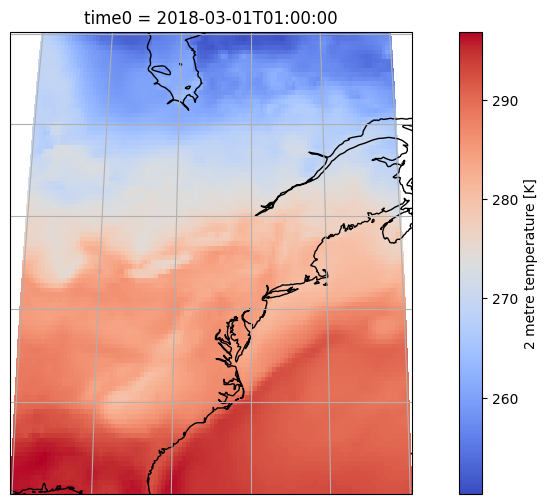

In [26]:
# Keeping plotting easy
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude = 285))
ax.coastlines()
ax.gridlines()

air_tmp.isel(time0=1).plot(ax=ax,transform=ccrs.PlateCarree(), cmap="coolwarm");

The tutorial uses more complicated plotting functions which we could use here as well, particularly for interactive plots of hourly/daily temperature variability

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
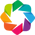

:Overlay
   .Image.I     :Image   [lon,lat]   (air_temperature_at_2_metres)
   .Coastline.I :Feature   [Longitude,Latitude]

In [43]:
holoviews.extension("bokeh")

dataset_plot = gvDataset(air_tmp.isel(time0=0))  # select the first time step

# create the image
images = dataset_plot.to(gvImage, ["longitude", "latitude"], ["air_temperature_at_2_metres"], "hour")

# aesthetics, add coastlines etc.
images.opts(cmap="coolwarm", colorbar=True, width=600, height=400, projection=ccrs.PlateCarree(),clabel="2m Air Temperature [K]") * gf.coastline

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
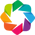

:HoloMap   [hour]
   :Overlay
      .Image.I     :Image   [lon,lat]   (air_temperature_at_2_metres)
      .Coastline.I :Feature   [Longitude,Latitude]

In [46]:
holoviews.extension("bokeh")

air_tmp_hr = air_tmp.groupby("time0.hour").mean()
dataset_plot = gvDataset(air_tmp_hr.isel(hour=slice(0, 23)))

# create the image
images = dataset_plot.to(gvImage, ["longitude", "latitude"], ["air_temperature_at_2_metres"], "hour")

# aesthetics, add coastlines etc.
images.opts(cmap="coolwarm", colorbar=True, width=600, height=400, projection=ccrs.PlateCarree(),clabel="2m Air Temperature [K]") * gf.coastline


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
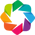

:HoloMap   [day]
   :Overlay
      .Image.I     :Image   [lon,lat]   (air_temperature_at_2_metres)
      .Coastline.I :Feature   [Longitude,Latitude]

In [50]:
holoviews.extension("bokeh")
air_tmp_day = air_tmp.groupby("time0.day").mean()
dataset_plot = gvDataset(air_tmp_day.isel(day=slice(0,10)))
images = dataset_plot.to(gvImage, ["longitude", "latitude"], ["air_temperature_at_2_metres"], "day")
images.opts(cmap="coolwarm", colorbar=True, width=600, height=400, projection=ccrs.PlateCarree(),clabel="2m Air Temperature [K]") * gf.coastline


Unsurprisingly, the variations in hourly temperatures are clearer at a specific location compared to diurnial variations.

### Plotting the timeseries of temperature variation

Remember the Earth is round, not flat, so use cos and sin to get spatial averages

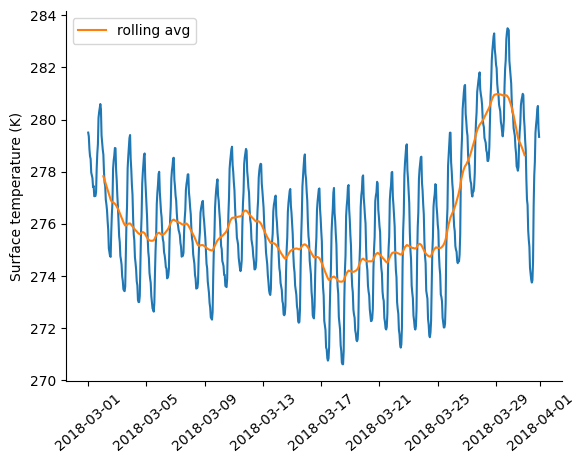

In [71]:
weights = np.cos(np.deg2rad(air_tmp.lat))
weights.name = "weights" # What does this do?
# weights

air_tmp_ts = air_tmp.weighted(weights).mean(["lat", "lon"])
# air_tmp_ts

f, ax = plt.subplots()
ax.plot(air_tmp_ts["time0"], air_tmp_ts);
ax.plot(air_tmp_ts["time0"], air_tmp_ts.rolling(time0=50, center=True).mean(), label='rolling avg')
ax.xaxis.set_tick_params(rotation=40);
sns.despine()
ax.set_ylabel("Surface temperature (K)");
ax.legend();

The short term variability is likely daily temperature variability and the long-term is synoptic (~5 day variability)

Would the ENSO variability show up here? Hmm maybe, maybe not. This is the average across the entire earth (I think), so not sure how much variation would be caused by the small part of the earth that experiences the variability. Moreover, this data is only for a month, while the ENSO variability happens over a year, so don't think it will show up here

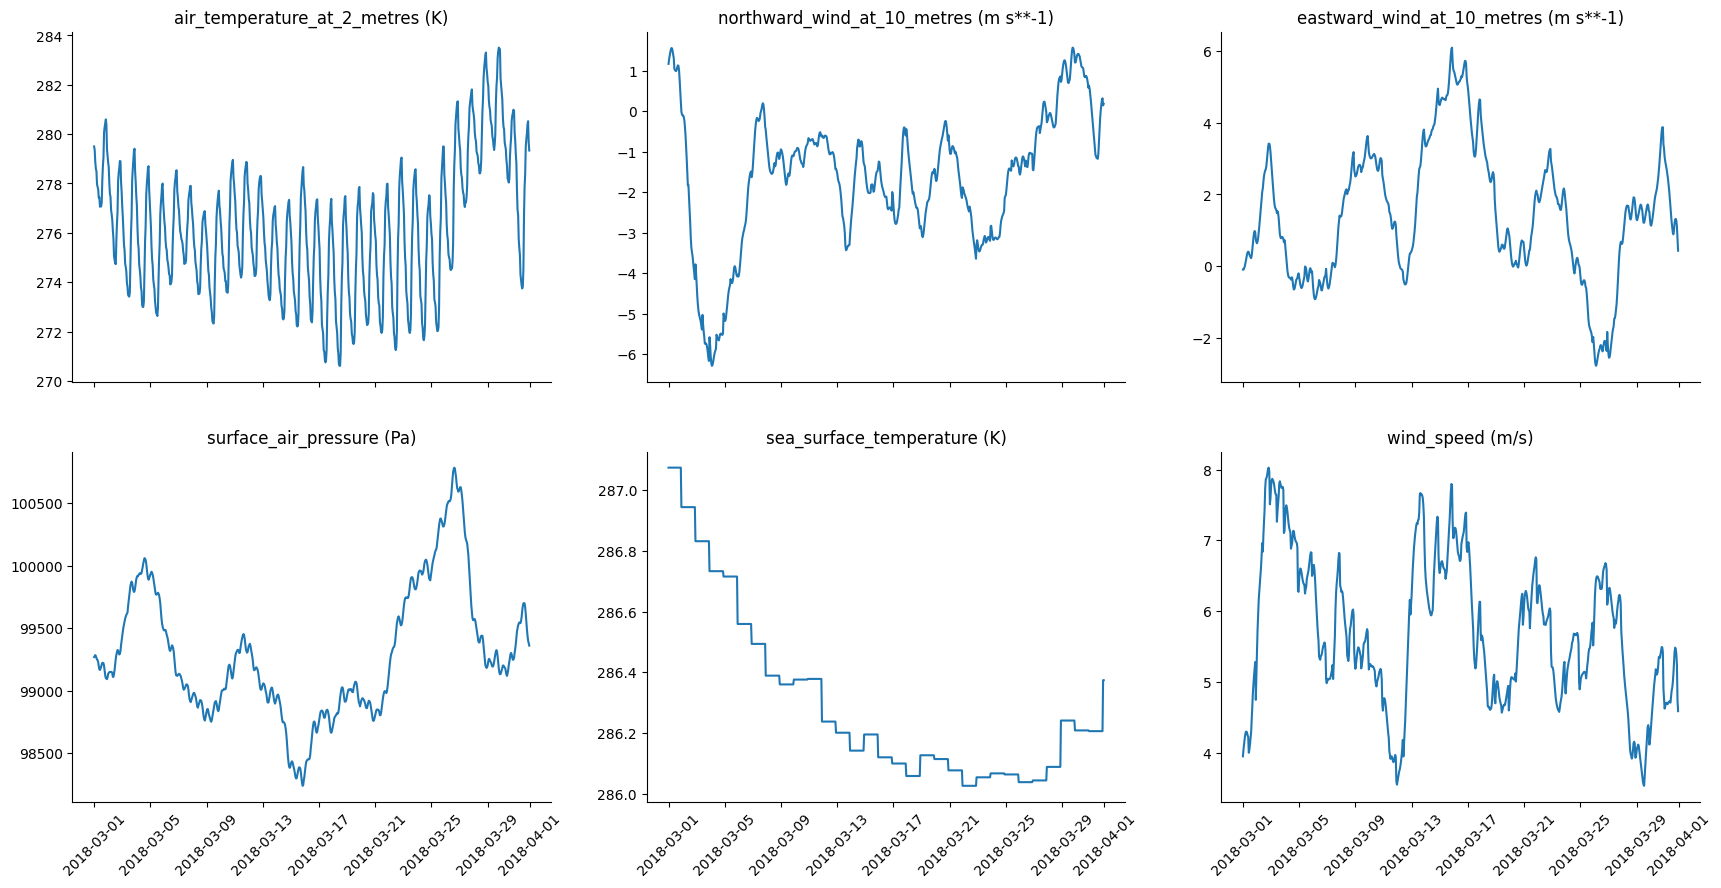

In [90]:
# Let's plot all other variabiles in this dataset
all_vars = list(ERA5_allvars.data_vars)

f, ax = plt.subplots(2,3,sharex=True, figsize=(21,10)); ax=ax.flatten()
for ivar, var in enumerate(all_vars):
    dat = ERA5_allvars[var].weighted(weights).mean(["lat", "lon"])
    ax[ivar].plot(dat["time0"], dat); sns.despine()
    ax[ivar].set_title(f"{var} ({ERA5_allvars[var].attrs['units']})")
    ax[ivar].tick_params(axis='x', rotation=45);

Quite intriguing how wind speed/pressure changes at a 5-ish day cycle. Unsurprising that they change together tho